In [207]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from scipy.optimize import minimize
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')

In [200]:
mu = 0
sigma = 1
eps = 1e-3

alpha = np.random.random_sample()
beta = np.random.random_sample()

alpha, beta

(0.07106191077144719, 0.0022176061943156578)

In [214]:
s = np.random.normal(mu, sigma, 1001)
vector = np.array([(i/1000, alpha * i/1000 + beta + s[i]/20) for i in range(1001)])

In [202]:
def D_linear(t, shape="float"):
    a, b = t[0], t[1]
    x, y = vector[:, 0], vector[:, 1]
    if shape == "tuple":
        return ((a * x + b - y) ** 2).sum(), 0
    return ((a * x + b - y) ** 2).sum()

def D_rational(t, shape="float"):
    a, b = t[0], t[1]
    x, y = vector[:, 0], vector[:, 1]
    if shape == "tuple":
        return ((a / (1 + b * x) - y) ** 2).sum(), 0
    return ((a / (1 + b * x) - y) ** 2).sum()

def D_liniar_der(t, shape="float"):
    a, b = t[0], t[1]
    x, y = vector[:, 0], vector[:, 1]
    if shape == 'tuple':
        return np.array([[(2*x*(a * x + b - y)).sum(), (2*(a * x + b - y)).sum()],
                         [0, 0]])
    return np.array([(2*x*(a * x + b - y)).sum(),
                     (2*(a * x + b - y)).sum()])

def D_rational_der(t, shape="float"):
    a, b = t[0], t[1]
    x, y = vector[:, 0], vector[:, 1]
    if shape == 'tuple':
        return np.array([[(-2 * (-a + y + b * x * y) / (1 + b * x) ** 2).sum(),
                          (-2 * a * b * (a - y * (1 + b * x)) / (1 + b * x) ** 2).sum()],
                         [0, 0]])
    return np.array([(-2 * (-a + y + b * x * y) / (1 + b * x) ** 2).sum(),
                     (-2 * a * b * (a - y * (1 + b * x)) / (1 + b * x) ** 2).sum()])

In [203]:
def gradient_descent(func, grad_func, tmp, tol, step=0.00075, max_iter=1000):
    for i in range(max_iter):
        f_val = func(tmp)
        grad_value = grad_func(tmp)
        
        a_tmp = tmp[0] - step * grad_value[0]
        b_tmp = tmp[1] - step * grad_value[1]
        tmp = [a_tmp, b_tmp]
        
        f_new_val = func(tmp)
        if abs(f_new_val - f_val) <= tol:
            return {'fun': f_new_val,
                    'x': [a_tmp, b_tmp],
                    'nit': i}

In [215]:
start = -1
stop = 1


report = pd.DataFrame()
flag = 40
while(flag > 3):
    report = pd.DataFrame()
    a_init = random.uniform(start, stop)
    b_init = random.uniform(start, stop)
    try:
        for function, derivative in zip([D_linear, D_rational],[D_liniar_der, D_rational_der]):

            gd_result = gradient_descent(function, derivative, [a_init, b_init], tol=eps)
            newtons = minimize(function, [a_init, b_init], method='Newton-CG', tol=eps, jac=derivative)
            cgd = minimize(function, [a_init, b_init], method='CG', tol=eps)
            lm = optimize.root(function, [a_init, b_init], method='lm', tol=eps, args = ('tuple'), jac=derivative)

            res = [[function.__name__, 'Gradient Descent', gd_result['x'], gd_result['nit'], gd_result['fun']],
                   [function.__name__,'Newton’s method', newtons.x, newtons.nit, newtons.fun],
                   [function.__name__, 'Conjugate Gradient Descent', cgd.x, cgd.nit, cgd.fun],
                   [function.__name__, 'Levenberg-Marquardt algorithm', lm.x, lm.nfev, lm.fun[0]]]
            if (function.__name__ == "D_rational"): flag = newtons.fun

            report = report.append(res, ignore_index=True)
    except TypeError:
        continue
    
report.columns = ["function name", "method name", "arg", "nit", 'fval']
report = report.set_index(['function name', 'method name']).sort_index()
report

arg  \
function name method name                                                                   
D_linear      Conjugate Gradient Descent     [0.06815753457065439, 0.0027572670891151223]   
              Gradient Descent                [0.06386317612700472, 0.006407829755698745]   
              Levenberg-Marquardt algorithm  [0.06773565386028209, 0.0030478992028984218]   
              Newton’s method                 [0.06815961094447319, 0.002756635412683131]   
D_rational    Conjugate Gradient Descent      [0.021460401800892162, -0.7213980836238708]   
              Gradient Descent                 [0.03886539734772032, 0.18909372881272532]   
              Levenberg-Marquardt algorithm    [0.03873127547256046, 0.14177586719567517]   
              Newton’s method                  [0.038884564779230975, 0.1746029686513181]   

                                             nit      fval  
function name method name                                   
D_linear      Conjugate Gradient Descent       8  2.520988  
              Gradient Descent                42  2.524792  
              Levenberg-Marquardt algorithm   53  2.521009  
              Newton’s method                  4  2.520988  
D_rational    Conjugate Gradient Descent      12  2.611302  
              Gradient Descent                 5  2.984567  
              Levenberg-Marquardt algorithm   11  2.966513  
              Newton’s method                  2  2.979062

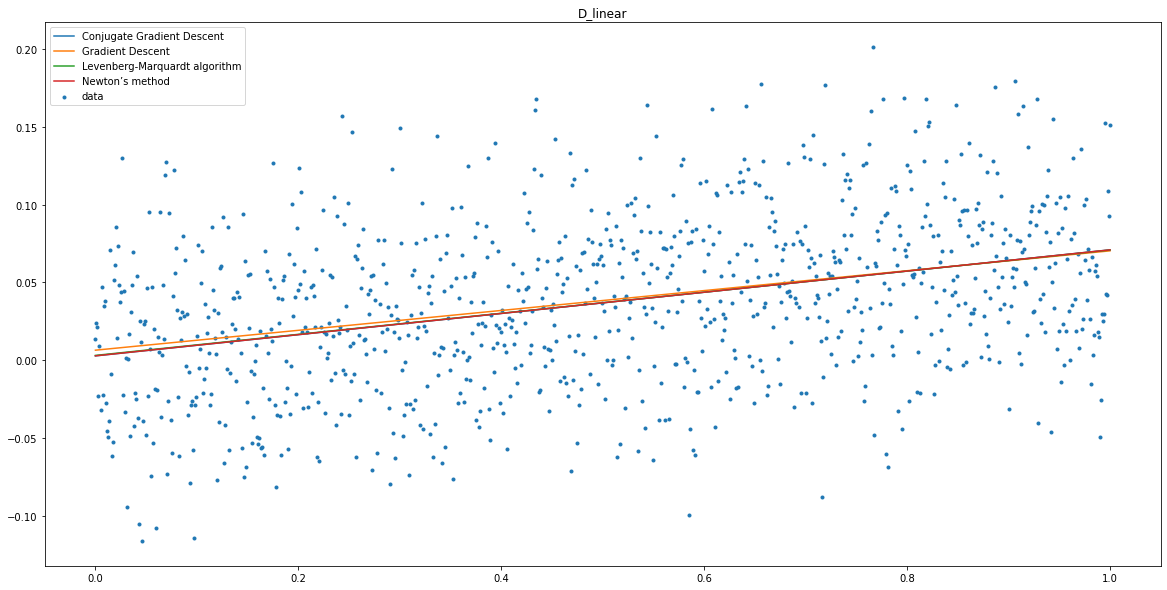

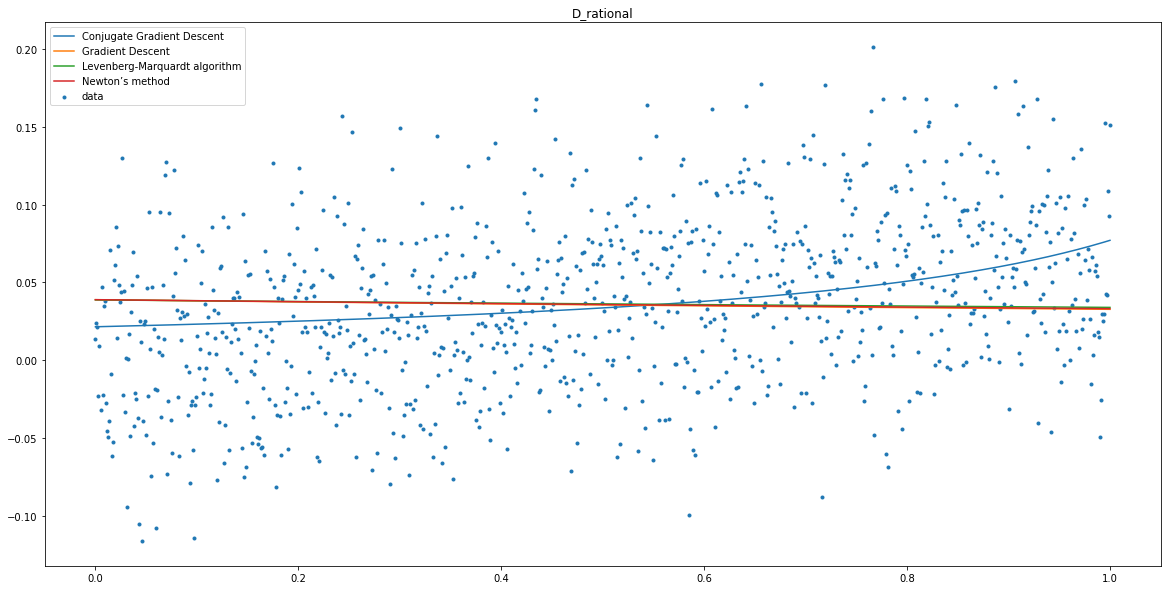

In [216]:
for i, func in enumerate(report.index.levels[0]):
    fig = plt.figure(figsize=(20,10))
    plt.scatter(vector[:,0], vector[:,1], label = 'data', marker='.')
    for method in report.index.levels[1]:
        example = report.loc[func, method]
        if func == 'D_linear':
            plt.plot(vector[:,0], example['arg'][0] * vector[:,0] + example['arg'][1], label = method)
        if func == 'D_rational':
            plt.plot(vector[:,0], example['arg'][0] / (1 + example['arg'][1] * vector[:,0]), label = method)
    plt.title(func)
    plt.legend()
    plt.savefig("pictures/"+func+".png")
    plt.show()
    plt.close(fig)